In [4]:
import os, glob, wave
import torch, torchaudio
import numpy as np
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm

In [5]:
# ----- Config -----
SR           = 22050
WINDOW_SEC   = 5
overlap      = 0.5
WINDOW_SIZE  = int(SR * WINDOW_SEC)
HOP_SIZE     = int(WINDOW_SIZE * (1 - overlap))
N_MELS       = 64
BATCH_SIZE   = 32
TEST_SPLIT   = 0.2
RANDOM_SEED  = 42
NUM_WORKERS  = 2
LEARNING_RATE= 1e-4
MAX_EPOCHS   = 100
BETA         = 1.0
PATIENCE     = 10

In [6]:
FEATURE_FILE = 'all_features.pt'
arterial_dir = '/content/Arterial_side'
venous_dir   = '/content/Vein_side'

In [7]:
# ----- Transforms -----
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=1024, hop_length=512, n_mels=N_MELS
)
to_db = torchaudio.transforms.AmplitudeToDB()
resampler_cache = {}

In [8]:
def load_wave(fp):
    try:
        wav, orig_sr = torchaudio.load(fp)
    except RuntimeError:
        with wave.open(fp, 'rb') as wf:
            orig_sr = wf.getframerate()
            data = wf.readframes(wf.getnframes())
            audio_np = np.frombuffer(data, dtype=np.int16).astype(np.float32) / np.iinfo(np.int16).max
            wav = torch.from_numpy(audio_np).unsqueeze(0)
    return wav, orig_sr

In [9]:

def preprocess_features(paths, feature_file):
    if os.path.exists(feature_file):
        print(f"Loading precomputed features from {feature_file}")
        return torch.load(feature_file)
    print("Preprocessing audio files into feature windows...")
    feats = []
    for fp in tqdm(paths, desc="WAV → mel-mean"):
        wav, orig_sr = load_wave(fp)
        if orig_sr != SR:
            if orig_sr not in resampler_cache:
                resampler_cache[orig_sr] = torchaudio.transforms.Resample(orig_sr, SR)
            wav = resampler_cache[orig_sr](wav)
        wav = wav.mean(dim=0).clamp(-1,1)
        for st in range(0, wav.size(1) - WINDOW_SIZE + 1, HOP_SIZE):
            seg = wav[:, st:st + WINDOW_SIZE]
            spec_db = to_db(mel_spec(seg))
            feats.append(spec_db.mean(dim=-1))
    feats_t = torch.stack(feats)
    torch.save(feats_t, feature_file)
    print(f"Saved {len(feats)} windows → {feature_file}")
    return feats_t

In [10]:
class VAE(nn.Module):
    def __init__(self, input_dim=N_MELS, hidden_dim=32, latent_dim=16):
        super().__init__()
        self.fc1      = nn.Linear(input_dim, hidden_dim)
        self.fc_mu    = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar= nn.Linear(hidden_dim, latent_dim)
        self.fc2      = nn.Linear(latent_dim, hidden_dim)
        self.fc3      = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = F.relu(self.fc1(x)); return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = (0.5*logvar).exp(); return mu + torch.randn_like(std)*std
    def decode(self, z):
        return self.fc3(F.relu(self.fc2(z)))
    def forward(self, x):
        mu, lv = self.encode(x); z = self.reparameterize(mu, lv)
        return self.decode(z), mu, lv

In [ ]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    # 1) gather .wav paths
    paths = glob.glob(f'{arterial_dir}/*.wav') + glob.glob(f'{venous_dir}/*.wav')

    # 2) load or compute features
    features = preprocess_features(paths, FEATURE_FILE)
    ds = TensorDataset(features)
    n_val = int(len(ds)*TEST_SPLIT)
    train_ds, val_ds = random_split(ds, [len(ds)-n_val, n_val],
                                    generator=torch.Generator().manual_seed(RANDOM_SEED))
    tl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS, pin_memory=True)
    vl = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=True)

    # 3) build model & optimizer
    vae       = VAE().to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
    sched     = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

    best, wait = float('inf'), 0
    for epoch in range(1, MAX_EPOCHS+1):
        # train
        vae.train(); train_loss=0
        for batch in tl:
            x = batch[0].to(device)
            optimizer.zero_grad()
            recon, mu, lv = vae(x)
            mse = F.mse_loss(recon, x, reduction='sum')
            kld = -0.5*torch.sum(1 + lv - mu.pow(2) - lv.exp())
            loss = mse + BETA*kld
            loss.backward(); optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_ds)

        # validate
        vae.eval(); val_loss=0
        with torch.no_grad():
            for batch in vl:
                x = batch[0].to(device)
                recon, mu, lv = vae(x)
                val_loss += (F.mse_loss(recon, x, reduction='sum')
                             -0.5*torch.sum(1 + lv - mu.pow(2) - lv.exp())).item()
        val_loss /= len(val_ds)

        print(f"Epoch {epoch} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
        sched.step(val_loss)

        if val_loss < best:
            best, wait = val_loss, 0
            torch.save(vae.state_dict(), 'best_vae.pth')
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping.")
                break

    print("Done. Best Val Loss:", best)

if __name__ == '__main__':
    main()

Device: cuda
Loading precomputed features from all_features.pt
Epoch 1 | Train: 26387.6637 | Val: 8204.1804
Epoch 2 | Train: 5066.7929 | Val: 2933.7186
Epoch 3 | Train: 2169.7602 | Val: 1649.5160
Epoch 4 | Train: 1369.3148 | Val: 1152.4095
Epoch 5 | Train: 1010.1814 | Val: 897.0548
Epoch 6 | Train: 805.4365 | Val: 726.9099
Epoch 7 | Train: 655.6511 | Val: 591.0896
Epoch 8 | Train: 526.7476 | Val: 475.7674
Epoch 9 | Train: 436.5004 | Val: 406.1193
Epoch 10 | Train: 379.9017 | Val: 359.8693
Epoch 11 | Train: 340.4507 | Val: 325.6428
Epoch 12 | Train: 310.5737 | Val: 299.8492
Epoch 13 | Train: 286.5914 | Val: 277.2036
Epoch 14 | Train: 266.0065 | Val: 257.4266
Epoch 15 | Train: 246.1411 | Val: 237.8733
Epoch 16 | Train: 227.5386 | Val: 219.1825
Epoch 17 | Train: 207.2400 | Val: 200.0018
Epoch 18 | Train: 192.6825 | Val: 189.2665
Epoch 19 | Train: 184.2930 | Val: 182.8284
Epoch 20 | Train: 177.9040 | Val: 178.1015
Epoch 21 | Train: 172.2056 | Val: 170.2293
Epoch 22 | Train: 167.4850 | Val:

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1) Rebuild  dataset & loader exactly as in training
features = torch.load('all_features.pt')           
ds       = TensorDataset(features)
n_val    = int(len(ds) * TEST_SPLIT)
_, val_ds = random_split(
    ds,
    [len(ds) - n_val, n_val],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# 2) Reconstruct VAE & load the best weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae    = VAE().to(device)
vae.load_state_dict(torch.load('best_vae.pth', map_location=device))
vae.eval()

# 3) Compute total variance of features 
feat_var = features.var(dim=0).mean().item()

# 4) Run through val set to get MSE
mse_sum = 0.0
n_elems = 0
with torch.no_grad():
    for (x_batch,) in val_loader:
        x_batch = x_batch.to(device)
        recon, _, _ = vae(x_batch)
        mse_sum += F.mse_loss(recon, x_batch, reduction='sum').item()
        n_elems += x_batch.numel()

mse_mean = mse_sum / n_elems
r2_score = 1.0 - (mse_mean / feat_var)

print(f"Validation MSE per feature: {mse_mean:.4f}")
print(f"Reconstruction R² score:    {r2_score:.4f}")


Validation MSE per feature: 0.4756
Reconstruction R² score:    0.9915


CUDA available: True
CUDA device: Tesla T4
Model loaded on cuda:0


,side,file,mse
0,arterial,20190923_071811.wav,0.722044
1,arterial,20190924_051500.wav,31.417358
2,arterial,20190925_060006.wav,12.542744
3,arterial,20190926_053529.wav,16.499710
4,arterial,20190927_045841.wav,8.927897
...,...,...,...
550,venous,20200815_054823.wav,1.872856
551,venous,20200816_062211.wav,0.689582
552,venous,20200817_044509.wav,1.127181
553,venous,20200818_045614.wav,11.799072


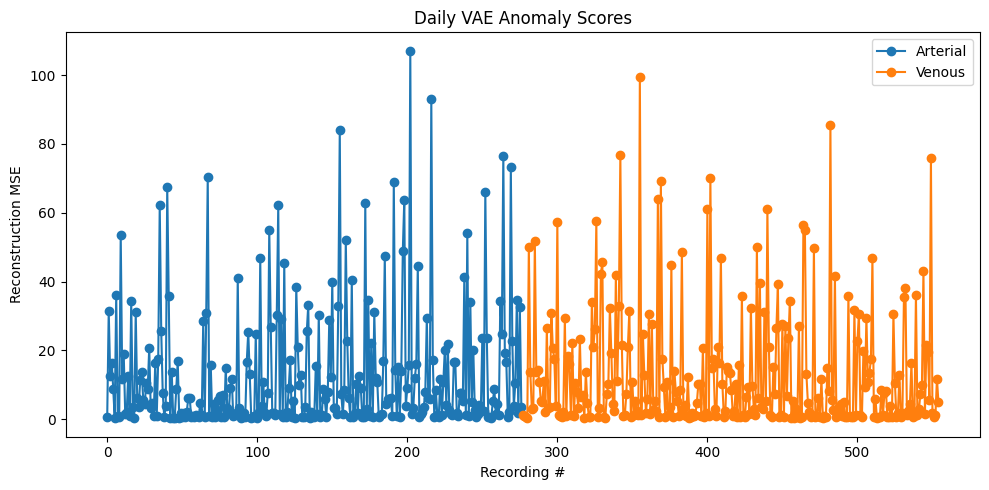

In [ ]:
# ==== 1) CHECK GPU ====
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# ==== 2) INSTANTIATE & LOAD YOUR VAE ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE().to(device)

# Load the state dict from best_vae.pth
state_dict = torch.load("best_vae.pth")
vae.load_state_dict(state_dict)
vae.eval()
print("Model loaded on", next(vae.parameters()).device)

# ==== 3) DEFINE RECONSTRUCTION‐ERROR FUNCTION ====
import librosa

def compute_recon_error(path):
    # 1️ Load and compute Mel-spectrogram
    y, sr = librosa.load(path, sr=44100)
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    logm = librosa.power_to_db(mels)
    # 2️ Collapse over time → N_MELS vector
    vec = logm.mean(axis=1)
    # 3️ Normalize
    norm = (vec - vec.mean()) / vec.std()
    tensor = torch.from_numpy(norm).unsqueeze(0).float().to(device)
    # 4️ Forward pass & MSE
    with torch.no_grad():
        recon, mu, lv = vae(tensor)
    return ((tensor - recon) ** 2).mean().item()


# ==== 4) SCAN FOLDERS & BUILD A DATAFRAME ====
import os
import pandas as pd

records = []
for side, folder in [("arterial", "Arterial_side"), ("venous", "Vein_side")]:
    for fname in sorted(os.listdir(folder)):
        if fname.lower().endswith(".wav"):
            mse = compute_recon_error(os.path.join(folder, fname))
            records.append({"side": side, "file": fname, "mse": mse})

df = pd.DataFrame(records)
display(df)  

# ==== 5) PLOT  ANOMALY SCORES ====
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for side, grp in df.groupby("side"):
    plt.plot(grp.index, grp["mse"], marker="o", label=side.capitalize())
plt.xlabel("Recording #")
plt.ylabel("Reconstruction MSE")
plt.title("Daily VAE Anomaly Scores")
plt.legend()
plt.tight_layout()
plt.show()


Arterial: μ=12.26, σ=13.21, threshold=51.91
Venous: μ=12.88, σ=16.29, threshold=61.74

Anomalous recordings:


,side,file,mse,anomaly
9,arterial,20191003_052306.wav,53.672173,True
35,arterial,20191029_050510.wav,62.186012,True
40,arterial,20191103_045309.wav,67.445206,True
67,arterial,20191130_054547.wav,70.278809,True
108,arterial,20200113_061421.wav,55.134933,True
114,arterial,20200119_062854.wav,62.202438,True
155,arterial,20200301_045455.wav,83.940948,True
159,arterial,20200305_045652.wav,52.006989,True
172,arterial,20200318_045406.wav,62.910744,True
191,arterial,20200407_052510.wav,68.924606,True


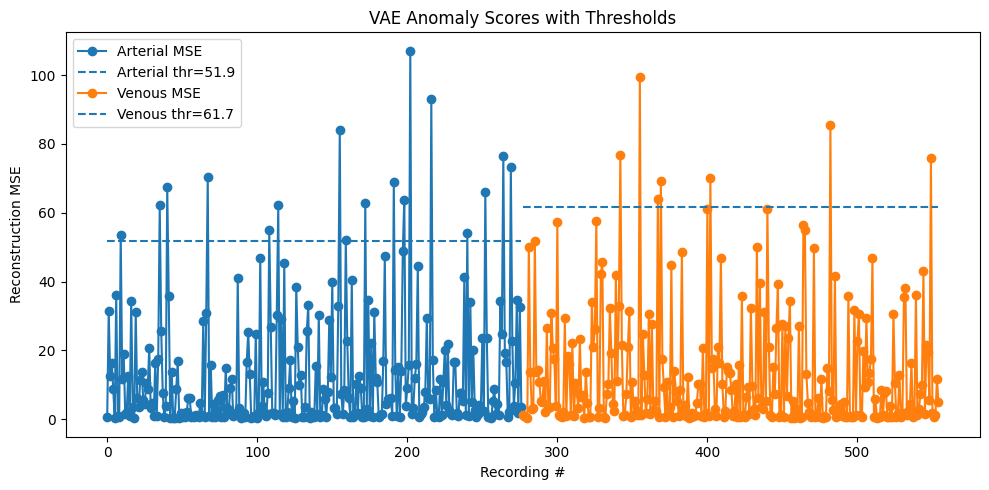

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) CHOOSE BASELINE LENGTH & STD‐MULTIPLIER
BASELINE_DAYS = 30
K = 3

# 2) COMPUTE THRESHOLDS & FLAG ANOMALIES
thresholds = {}
df['anomaly'] = False

for side, grp in df.groupby('side'):
    # use the first N days as baseline
    baseline = grp.head(BASELINE_DAYS)['mse']
    mu, sigma = baseline.mean(), baseline.std()
    T = mu + K * sigma
    thresholds[side] = (mu, sigma, T)

    # flag anomalies
    is_side = df['side'] == side
    df.loc[is_side, 'anomaly'] = df.loc[is_side, 'mse'] > T

# 3) SHOW THRESHOLDS
for side,(mu,sig,T) in thresholds.items():
    print(f"{side.capitalize()}: μ={mu:.2f}, σ={sig:.2f}, threshold={T:.2f}")

# 4) LIST ALL ANOMALY RECORDINGS
print("\nAnomalous recordings:")
display(df[df['anomaly']])

# 5) PLOT WITH THRESHOLD LINES
plt.figure(figsize=(10,5))
for side, grp in df.groupby('side'):
    plt.plot(grp.index, grp['mse'], marker='o', label=f"{side.capitalize()} MSE")
    mu, sig, T = thresholds[side]
    # draw horizontal threshold
    plt.hlines(T, xmin=grp.index.min(), xmax=grp.index.max(),
               linestyles='--', label=f"{side.capitalize()} thr={T:.1f}")

plt.xlabel("Recording #")
plt.ylabel("Reconstruction MSE")
plt.title("VAE Anomaly Scores with Thresholds")
plt.legend()
plt.tight_layout()
plt.show()
